# PyTorch Custom Datasets

PyTorch has many built-in datasets used for a wide number of machine learning benchmarks, however, you'll often want to use your own custom dataset.

A custom dataset is a collection of data relating to a specific problem you're working on.
In essence, a custom dataset can be comprised of almost anything (맞춤형 데이터셋은 거의 어떤 형태로든 구성 가능함)

PyTorch includes many existing functions to load in various custom datasets in the TorchVision, TorchText, TorchAudio and TorchRec domain libraries
But sometimes these existing functions may not be enough
In that case, we can always subclass torch.utils.data.Dataset and customize it to our liking (torch.utils.data.Dataset을 상속하여 원하는 방식으로 커스터마이징 가능)

0. Importing PyTorch and setting up device-agnostic code
1. Get data

2. Become one with the data (data preparation)
 - At the beginning of any new machine learning problem, it's paramount to understand the data you're working with. Here we'll take some steps to figure out what data we have

3. Transforming data 
 - Often, the data you get won't be 100% ready to use with a machine learning model, here we'll look at some steps we can take to transform our images so they're ready to be used with a model  
 (대부분의 경우, 데이터를 바로 모델에 사용할 수 없음, 여기서 이미지를 모델에 맞게 변환하는 방법을 배움)

4. Loading data with ImageFolder(option 1)
 - PyTorch has many in-built data loading functions for common types of data. ImageFolder is helpful if our images are in standard image classification format
 (PyTorch에는 일반적인 데이터 형식에 맞는 데이터 로딩 함수들이 내장되어 있음, 이미지가 일반적인 분류 구조라면 ImageFolder를 사용하는 것이 유용함)

5. Loading image data with a custom Dataset
 - What if PyTorch didn't have an in-built function to load data with? This is where we can build our own custom subclass of torch.utils.data.Dataset
 (PyTorch에 해당 데이터를 불러올 수 있는 내장 함수가 없을 때는 torch.utils.data.Dataset을 상속받아 직접 사용자 정의 데이터셋 클래스를 만들 수 있음)

6. Other forms of transforms (data augmentation(증강))
 - Data augmentation is a common technique for expanding the diversity of your training data. Here we'll explore some of torchvision's in-built data augmentation functions.
 (데이터 증강은 훈련 데이터의 다양성을 높이기 위한 일반적인 기법임)

7. Model 0: TinyVGG without data augmentation 
 - By this stage, we'll have our data ready, build a model capable of fitting it, also create some training and testing functions for training and evaluating our model

8. Exploring loss curves 
 - Loss curves are a great way to see how your model is training/improving over time. They're also a good way to see if model is uderfitiing(과소적합) or overfitting

9. Model 1: TinyVGG with data augmentation

10. Compare model results

11. Making a prediction on a custom image

In [2]:
# Importing PyTorch and setting up device-agnostic code
import torch
from torch import nn

print(torch.__version__)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

2.7.1+cu126
cuda


In [4]:
# Get data

# Machine learning is an iterative process, start small, get something working and increase when necessary
# formatted data (전처리된 데이터)

# The dataset we're about to use has been pre-formatted for what we'd like to use it for
# However, you'll often have to format your own datasets for whatever problem you're working on. 
# This is a regular practice in the machine learning world  (실제 머신러닝 작업에서는 대부분 직접 데이터셋을 전처리해야함, 머신러닝 분야에서 일상적인 작업임)

import requests
import zipfile  # 압축 파일(zip)의 압축을 푸는 데 사용
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():  # image_path 디렉토리가 이미 존재하는지 확인
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True) # parents=True : 상위 디렉토리(data/)도 없으면 자동 생성, exist_ok=True : 이미 존재해도 에러 발생하지 않음

    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content) # open()으로 열어둔 파일 객체 f에 대해 request.content를 바이너리로 저장
    
    # Unzip (압축해제)
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:  # .ZipFile() : ZipFile 객체를 생성 (.zip 파일을 열기 위한 도구, 이 객체를 통해 압축 해제, 파일 목록 조회 등의 작업을 할 수 있음)
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)  # extractall(image_path) : image_path 폴더(data/pizza_steak_sushi)에 압축 내용 모두 풀기 (.ZipFile()로 연 zip 파일 객체에 대해 모든 파일을 한 번에 압축 해제하는 메서드)

data\pizza_steak_sushi directory exists.


In [6]:
# Data preparation

# Before starting a project or building any kind of model, it's important to know what data working with
# image classification format : Contains separate classes of images in separate directories titled with a particular class name
# (이미지 분류 포맷이란, 각 클래스별 이미지가 각각의 폴더에 저장되어 있는 구조, 각 폴더는 해당 클래스의 이름을 폴더명으로 가짐)
# This format is popular across many different image classification benchmarks

# Find a way to best turn data into a dataset compatible with PyTorch (PyTorch와 호환되는 형식으로 변환할 최적의 방법을 찾아야함)

# We can inspect what's in our data directory by writing a small helper function to walk through each of the subdirectories and count the files present
# (데이터 디렉토리에 무엇이 들어 있는지 확인하려면, 각 하위 폴더를 순회하며 파일 개수를 세는 작은 보조 함수(helper function)를 작성함, os.walk())

import os
# Walks through dir_path returning its contents (os.walk()를 이용해 하위 폴더까지 모두 탐색함)
# os.walk() : 디렉토리 안을 반복하며, 각 위치에서 (dirpath, dirnames, filenames) 튜플을 순차적으로 반환 (현재 탐색 중인 폴더의 경로, dirpath 안에 있는 하위 폴더들의 이름 목록, dirpath 안에 있는 파일 이름들의 목록)
def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} driectories and {len(filenames)} image in '{dirpath}")

In [12]:
print(walk_through_dir(image_path),"\n")

There are 2 driectories and 0 image in 'data\pizza_steak_sushi
There are 3 driectories and 0 image in 'data\pizza_steak_sushi\test
There are 0 driectories and 25 image in 'data\pizza_steak_sushi\test\pizza
There are 0 driectories and 19 image in 'data\pizza_steak_sushi\test\steak
There are 0 driectories and 31 image in 'data\pizza_steak_sushi\test\sushi
There are 3 driectories and 0 image in 'data\pizza_steak_sushi\train
There are 0 driectories and 78 image in 'data\pizza_steak_sushi\train\pizza
There are 0 driectories and 75 image in 'data\pizza_steak_sushi\train\steak
There are 0 driectories and 72 image in 'data\pizza_steak_sushi\train\sushi
None 



In [15]:
train_dir = image_path / "train"
test_dir = image_path / "test"

print(train_dir)
print(test_dir)

train_dir, test_dir

data\pizza_steak_sushi\train
data\pizza_steak_sushi\test


(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

Random image path: data\pizza_steak_sushi\test\sushi\2394442.jpg
Image class: sushi
Image height: 408
Image width: 512


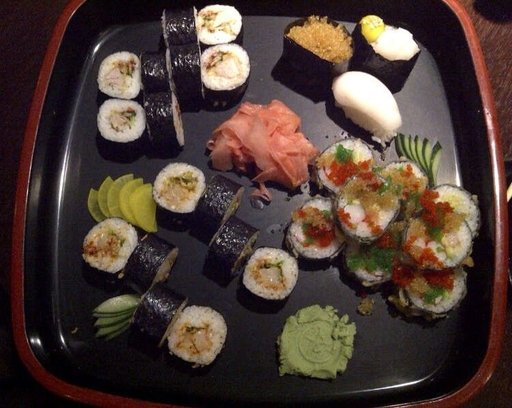

In [20]:
# Visualize an image

# 1. pathlib.Path.glob()를 사용해서 .jpg 확장자로 끝나는 모든 이미지 경로를 가져옴
# 2. Python의 random.choice()로 무작위 이미지 경로 선택
# 3. pathlib.Path.parent.stem을 사용해 선택한 이미지의 클래스 이름(class name) 얻기
# 4. Since we're working with images, open the random image path using PIL.Image.open() (PIL stands for Python Image Library)
# 5. Show the image and print some metadata

import random
from PIL import Image

random.seed(42)

image_path_list = list(image_path.glob("*/*/*.jpg"))

random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

(np.float64(-0.5), np.float64(511.5), np.float64(407.5), np.float64(-0.5))

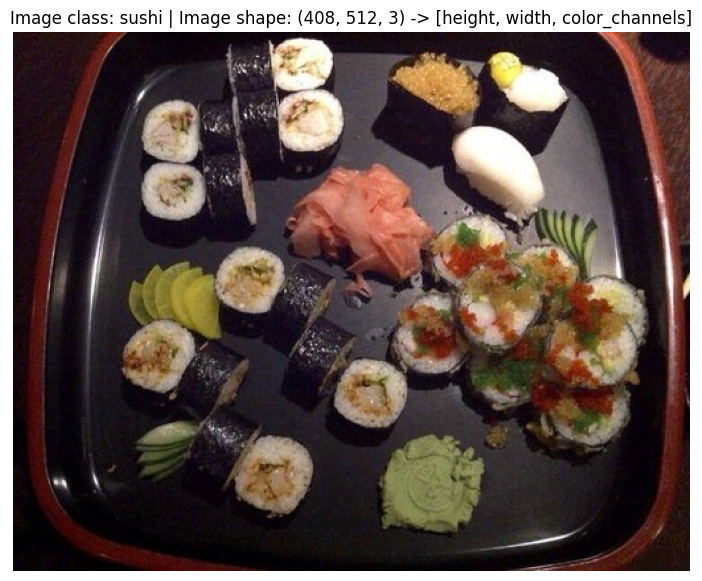

In [ ]:
# Do the same with matplotlib.pyplot.imshow()   (convert the image to a NumPy array first)
import numpy as np
import matplotlib.pyplot as plt

img_as_array = np.asarray(img)  # 다른 자료형을 NumPy배열로 변환

plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False)

# Transforming data

Turn image data into tensors (numerical representations of images)
Turn it into a torch.utils.data.Dataset and subsequently a torch.utils.data.DataLoader (call these Dataset and DataLoader for short)

1. Vision - torchvision.datasets
2. Audio - torchaudio.datasets
3. Text - torchtext.datasets
4. Recommendation system - torchrec.datasets


In [27]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Transforming data with torchvision.transforms

need to convert folders of images into tensors
One of the ways can do this is by using the vorchvision.transforms module
torchvision.transforms contains many pre-built methods for formatting images, turning them into tensors and even manipulating them for data augmentation
data augmentation : the practice of altering data to make it harder for a model to learn

1. Resize the images using transforms.Resize()
 + some models prefer images of different sizes and shapes

2. Flip our images randomly on the horizontal using transforms.RandomHorizontalFlip()  
 (transforms.RandomHorizontalFlip()을 사용하여 이미지를 좌우로 무작위 반전함)

3. Turn our images from a PIL image to a PyTorch tensor using transforms.ToTensor()

+ can compile all of these steps using torchvision.transforms.Compose()


Generally, the larger the shape of the image, the more information a model can recover (이미지의 크기가 클수록, 모델이 더 많은 정보를 얻을 수 있음)
The tradeoff is that more pixels requires more computations

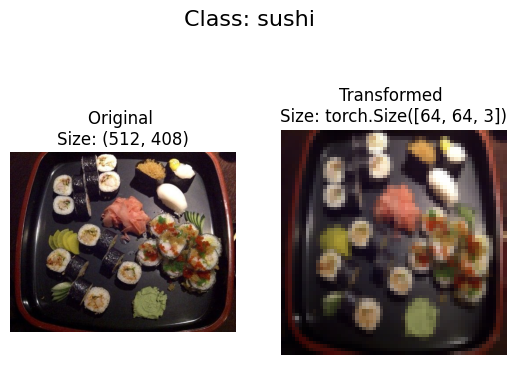

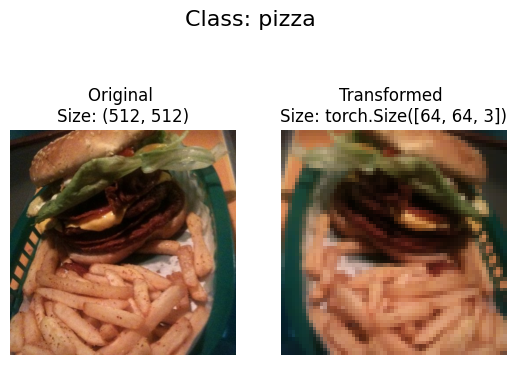

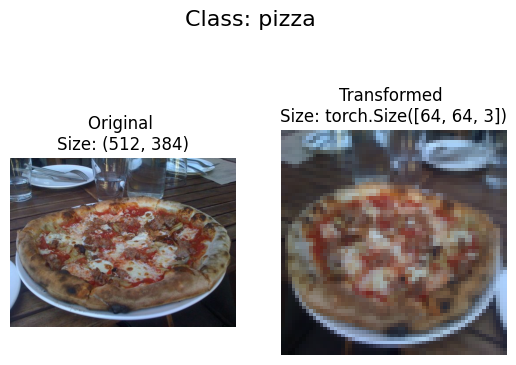

In [ ]:
data_transform = transforms.Compose([transforms.Resize(size=(64,64)),
                                     transforms.RandomHorizontalFlip(p=0.5),  # p = probability of flip, 0.5 = 50% chance
                                     transforms.ToTensor()])  # turn the image into a torch.Tensor
                                                              # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 (모든 픽셀 값을 0에서 255 사이의 정수에서 0.0에서 1.0 사이의 실수로 변환)

def plot_transformed_images(image_paths, transform, n=3, seed=42):  # transform : Transforms to apply to images
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)  # random.sample() : 리스트나 시퀀스에서 중복 없이 무자구이로 원하는 개수만큼의 항목을 뽑아오는 기능
    for image_path in random_image_paths:
        with Image.open(image_path) as f:  # PIL을 이용하여 이미지 열기
            fig, ax = plt.subplots(1,2)  # fig : 그래프 전체 영역, ax : 각각의 개별 그래프 공간
            ax[0].imshow(f) # ax[0] 좌측 개별 그래프 공간, 좌측에 원본 이미지 출력
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            transformed_image = transform(f).permute(1,2,0) # PyTorch는 [channel, height, width] -> Matplotlib은 [height,width, channel]이므로 순서 변경
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16) # .suptitle() 메서드는 fig 전체의 제목
                                                                          # image_path.parent : 상위 폴더 경로,  .stem : 경로의 마지막 부분(파일명 또는 폴더명)에서 확장자를 제외한 이름
                                                                          # image_path.parent.stem은 이미지가 속한 폴더 이름(클래스명)

plot_transformed_images(image_path_list,
                        transform=data_transform,
                        n=3)

In [36]:
# 4. Option1 : Loading Image Data Using ImageFolder

# torchvision.datasets.ImageFolder() : 폴더 구조를 기준으로 자동으로 이미지와 레이블(클래스)을 매칭해줌 (이미지가 저장된 폴더명을 기준으로 클래스를 분류)
# Since our data is in standard image classification format, can use the class torchvision.datasets.ImageFolder
# Where we can pass it the file path of a target image directory as well as a series of transforms we'd like to perform on our images.
# (이 클래스에 대상 이미지 폴더의 경로와, 이미지에 적용하고 싶은 여러 변환들을 전달할 수 있음)

from torchvision import datasets
train_data = datasets.ImageFolder(root= train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data(images)
                                  target_transform=None) # transforms to perform on labels (if necessary) (필요시 레이블에 적용할 변환, 초기값 None)
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data\pizza_steak_sushi\train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data\pizza_steak_sushi\test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [ ]:
# get class names as a list
class_names = train_data.classes  # torchvision.datasets.ImageFolder 객체는 자동으로 폴더 이름을 기반으로 클래스 목록을 만들고, 그 목록을 classes 속성에 리스트 형태로 저장함
print(class_names)

['pizza', 'steak', 'sushi']


In [ ]:
# get class names as a dict
class_dict = train_data.class_to_idx  # .class_to_idx : 클래스 이름(폴더명)과 인덱스를 매핑한 딕셔너리
print(class_dict)

{'pizza': 0, 'steak': 1, 'sushi': 2}


In [34]:
print(len(train_data), len(test_data))

225 75


In [40]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.01

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'pizza')

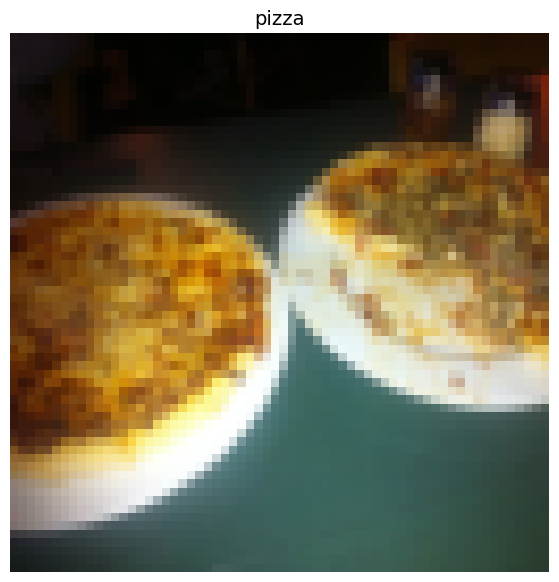

In [41]:
# have to permute (rearrange the order of its dimensions) so it's compatible. (permute를 사용해서 텐서의 차원 순서를 바꿔야함)
# Right now image dimensions are in the format CHW (color channels, height, width) but matplotlib prefers HWC (height, width, color channels).
img_permute = img.permute(1,2,0)

print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

plt.figure(figsize = (10,7))
plt.imshow(img.permute(1,2,0))
plt.axis("off")
plt.title(class_names[label], fontsize=14)

In [47]:
# Turn loaded images into DataLoader's (torch.utils.data.DataLoader)

# Turning Dataset's into DataLoader's makes them iterable so a model can go through and learn the relationships between samples and targets (features and labels)
# num_workers : It defines how many subprocesses will be created to load your data (데이터를 불러오기 위해 몇 개의 하위 프로세스를 생성할지 결정하는 값)
# num_workers의 값이 클수록, PyTorch는 데이터를 불러오기 위해 더 많은 컴퓨팅 자원(compute power)을 사용하게 됨
# os.cpu_count() : 내 컴퓨터의 전체 cpu 개수 (이와 같이 설정하면 DataLoader가 데이터를 불러올 때 최대한 많은 CPU 코어를 활용하게 됨)

from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset = train_data,
                              batch_size=1,
                              num_workers=1,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=1,
                             num_workers=1,
                             shuffle=False)

print(train_dataloader)
print(test_dataloader)

In [48]:
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


# Option 2: Loading Image Data with a Custom Dataset  (if a pre-built Dataset creator like torchvision.datasets.ImageFolder() didn't exist)

pros and cons of creating your own custom way to load Dataset's
  1. Can create a Dataset out of almost anything  /  Even though you could create a Dataset out of almost anything, it doesn't mean it will work
  2. Not limited to PyTorch pre-built Dataset functions / Using a custom Dataset often results in writing more code, which could be prone to errors or performance issues


In [49]:
# replicating torchvision.datasets.ImageFolder() by subclassing torch.utils.data.Dataset (the base class for all Dataset's in PyTorch).

# Python's os for dealing with directories (our data is stored in directories)
# Python's pathlib for dealing with filepaths (each of our images has a unique filepath)
# torch for all things PyTorch
# PIL's Image class for loading images
# torch.utils.data.Dataset to subclass and create our own custom Dataset
# torchvision.transforms to turn our images into tensors
# Various types from Python's typing module to add type hints to our code

import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [ ]:
# Creating a helper function to get class names

# write a helper function capable of creating a list of class names and a dictionary of class names and their indexes given a directory path.
# 1. Get the class names using os.scandir() to traverse(탐색하다) a target directory (ideally the directory is in standard image classification format).
  # (os.scandir()를 사용해 대상 디렉토리를 탐색하며 클래스 이름을 얻음(이 디렉토리는 이상적으로 표준 이미지 분류 포맷이어야함))
# 2. Raise an error if the class names aren't found (if this happens, there might be something wrong with the directory structure).
# 3. Turn the class names into a dictionary of numerical labels, one for each class.
  # (클래스 이름들을 각 클래스에 대한 숫자 레이블 딕셔너리로 변환)

target_directory = train_dir
print(f"Target directory: {target_directory}")

class_names_found = sorted([entry.name for entry in list(os.scandir(image_path / "train"))]) # entry는 os.DirEntry의 객체, 이 객체에서 파일 또는 폴더명에 해당하는 속성이 .name
print(f"Class names found: {class_names_found}")
# os.scandir로 해당 경로의 디렉토리를 스캔
# 이 디렉토리에 있는 모든 항목에 대해 각 항목의 이름 entry.name을 리스트로 만듦

Target directory: data\pizza_steak_sushi\train
Class names found: ['pizza', 'steak', 'sushi']


In [53]:
print(list(os.scandir(image_path / "train")))

[<DirEntry 'pizza'>, <DirEntry 'steak'>, <DirEntry 'sushi'>]


In [ ]:
def find_classes(directory:str) -> Tuple[List[str], Dict[str, int]]:
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())  # 디렉토리 안에 있는 항목들 중에서 폴더인 것만 골라내기 위한 조건 (is_dir())

    if not classes: # 하위 폴더가 없을 때 에러를 발생시킴
        raise FileNotFoundError(f"Couldn't find any classes in {directory}")
    
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

In [55]:
print(find_classes(train_dir))

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})


# Create a custom Dataset to replicate ImageFolder

1. Subclass torch.utils.data.Dataset

2. Initialize our subclass with a targ_dir parameter (the target data directory) and transform parameter (the option to transform our data if needed)
   (서브클래스의 생성자 함수(__init__)를 정의할 때, targ_dir과 transform 파라미터를 포함)

3. Create several attributes for paths (the paths of our target images), transform (the transforms we might like to use, this can be None), 
classes and class_to_idx (from our find_classes() function)

4. Create a function to load images from file and return them, this could be using PIL or torchvision.io (for input/output of vision data)
   (이미지 파일을 불러와 반환하는 함수를 만듦)

5. Overwrite(덮어쓰다) the __len__ method of torch.utils.data.Dataset to return the number of samples in the Dataset, 
this is recommended but not required. This is so you can call len(Dataset)
   (Dataset 안에 있는 샘플의 개수를 반환하는 __len__()메서드를 덮어씀, __len__메서드를 구현하면 len(Dataset)으로 쉽게 크기를 알 수 있음)

6. Overwrite the __getitem__ method of torch.utils.data.Dataset to return a single sample from the Dataset, this is required

In [ ]:
from torch.utils.data import Dataset

class ImageFolderCustom(Dataset): # torch.utils.data.Dataset을 상속
    def __init__(self, targ_dir: str, transform=None) -> None:
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))  # glob() : 패턴에 맞는 파일 경로를 찾아주는 함수  # targ_dir 디렉토리 하위의 각 클래스 폴더 안에 있는 모든 .jpg파일 경로를 리스트로 추출
        self.transform = transform
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # make function to load images
    def load_image(self, index: int) -> Image.Image:
        image_path = self.paths[index] # 경로를 통해 이미지를 열고 반환
        return Image.open(image_path)
    
    def __len__(self) -> int:
        return len(self.paths) #전체 데이터 샘플 수 반환
    
    # overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index:int) -> Tuple[torch.Tensor, int]:
        img = self.load_image(index) # 이미지 로드
        class_name = self.paths[index].parent.name  # expects path in data_folder/class_name/image.jpeg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx  # 변환된 이미지와 클래스 인덱스 반환
        else:
            return img, class_idx  # 원본 이미지와 클래스 인덱스 반환

In [58]:
# Augment train data
train_transforms = transforms.Compose([transforms.Resize((64,64)),
                                       transforms.RandomHorizontalFlip(p=0.5),
                                       transforms.ToTensor()])

# Don't augment test data, only reshape
test_transforms = transforms.Compose([transforms.Resize((64,64)),
                                      transforms.ToTensor()])

In [60]:
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform = test_transforms)
print(train_data_custom)
print(test_data_custom)

In [61]:
print(len(train_data_custom), len(test_data_custom))

225 75


In [62]:
print(train_data_custom.classes)

['pizza', 'steak', 'sushi']


In [63]:
print(train_data_custom.class_to_idx)

{'pizza': 0, 'steak': 1, 'sushi': 2}


In [65]:
# check for equality amongst our custom Dataset and ImageFolder Dataset
print((len(train_data_custom) == len(train_data)) & (len(test_data_custom) == len(test_data)))
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)

True
True
True


# Create a function to display random images

create a helper function called display_random_images() that helps us visualize images in Dataset's
1. Take in a Dataset and a number of other parameters such as classes (the names of our target classes), the number of images to display (n) and a random seed
   (Dataset과 함께, 클래스 이름들, 출력할 이미지 수(n), 랜덤 시드 등의 매개변수를 입력받음)

2. To prevent the display getting out of hand(통제되지 않는), we'll cap(최대치를 제한하다) n at 10 images
   (화면에 너무 많은 이미지가 뜨는 것을 방지하기 위해, n의 최대값을 10으로 제한)

3. Set the random seed for reproducible plots (if seed is set)

4. Get a list of random sample indexes (can use Pytho's random.sample() for this) to plot

5. Setup a matplotlib plot

6. Loop thorugh the random sample indexes found in step 4 and plot them with matplotlib

7. Make sure the smaple images are of shape HWC (height, width, color channels) so we can plot them

In [ ]:
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    
    # adjust display if n too high
    if n>10:
        n=10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display")
    
    if seed:
        random.seed(seed)
    
    # get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    plt.figure(figsize= (16,8))


    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # adjust image tensor shape for plotting(matplotlib): [color_channels, height, width] -> [height, width, color_channels]
        targ_image_adjust = targ_image.permute(1,2,0)

        plt.subplot(1,n,i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

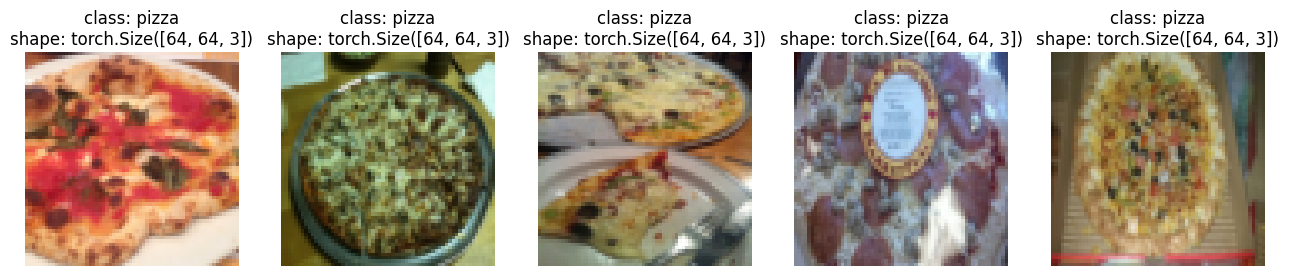

In [ ]:
# display random images from ImageFolder created Dataset
display_random_images(train_data,
                      n=5,
                      classes = class_names,
                      seed = None)

For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display


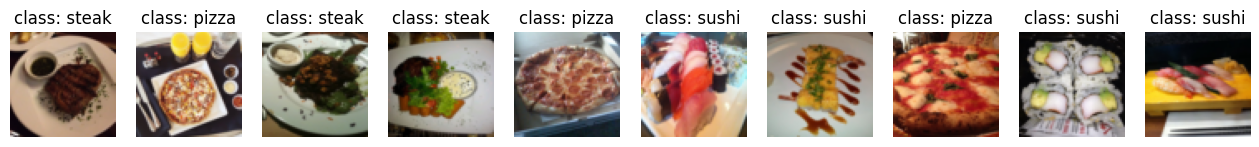

In [78]:
# display random images from ImageFolderCustom Dataset
display_random_images(train_data_custom,
                      n=12,
                      classes=class_names,
                      seed=None)

In [79]:
# Turn custom loaded images into DataLoader's

# Turn train and test custom Dataset's into DataLoader's
from torch.utils.data import DataLoader
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=1,
                                     num_workers=0,
                                     shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=1,
                                    num_workers=0,
                                    shuffle=False)

print(train_dataloader_custom)
print(test_dataloader_custom)

In [80]:
# get image and label from custom DataLoader
img_custom, label_custom = next(iter(train_dataloader_custom))

print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


# Other forms of transforms (data augmentation)

The purpose of transforms is to alter your images in some way
That may be turning your images into a tensor
Or cropping it or randomly erasing a portion or randomly rotating them
Doing these kinds of transforms is often referred to as data augmentation(데이터 증강)

Data augmentation is the process of altering your data in such a way that you artificially increase the diversity of your training set
(데이터 증강이란, 데이터를 변화시켜 훈련 데이터셋의 다양성을 인위적으로 증가시키는 과정)
Training a model on this artificially altered dataset hopefully results in a model that is capable of better generalization (the patterns it leaarns are more robust to future unseen examples)

Machine learning is all about harnessing(활용하는 것) the power of randomness and research shows that random transforms (like transforms.RandAugment() and transforms.TrivialAugmentWide()) generally perform better than hand-picked transforms.


# TrivialAugment
The idea behind TrivialAugment is trivial(단순한)
You have a set of transforms and you randomly pick a number of them to perform on an image and at a random magnitude between a given range (a higher magnitude means more intense)
(여러 가지 변형들을 모아놓고, 그 중 몇 개를 무작위로 선택해서 이미지에 적용함. 또한 변형의 강도(magnitude) 역시 주어진 범위 내에서 무작위로 정해짐(값이 클수록 더 강한 변형이 적용됨))

The main parameter to pay attention to in transforms.TrivialAugmentWide() is num_magnitude_bins=31
- num_magnitude_bins=31 : It defines how much of a range an intensity value will be picked to apply a certain transform, 0 being no range and 31 being maximum range (highest chance for highest intensity)
(이 값은 변형을 적용할 때 강도(intensity) 값이 어느 범위에서 선택되는지를 정의, 0이면 변화가 거의 없고, 31이면 가장 큰 범위 내에서 선택되므로 강도가 높을 확률이 커짐)

+ can incoporate transforms.TrivialAugmentWide() into transforms.Compose()

In [ ]:
from torchvision import transforms

train_transforms = transforms.Compose([transforms.Resize((224,224)),
                                       transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                       transforms.ToTensor()])

# Don't need to perform augmentation on the test data
test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor()])